# STA2453 - Data Science Methods, Collaboration, and Communication

# Credit Card Fraud Detection

### Team - Pulkit Mathur, Angad Kalra, Shuang Di

### Collaborator: Shobhit Jain and Adam Rahman (Data Scientists at Manulife)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import plotly
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,f1_score,recall_score,precision_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_validate
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
whole_data = pd.read_csv('credit_card_fraud_data_v2.csv')
whole_data.head()

,Time_Stamp,Transaction_Type,Amount,Client_Id,Client_Old_Balance,Cleint_New_Balance,Merchant_Id,Merchant_Old_Balance,Merchant_New_Balance,Is_Fraud,Is_Flagged_Fraud
0,1,BILL-PAYMENT,9839.64,C494672677,170136.0,160296.36,M582455116,0.0,0.0,0,0
1,1,BILL-PAYMENT,1864.28,C502607876,21249.0,19384.72,C214000796,0.0,0.0,0,0
2,1,PURCHASE,181.00,C633112680,181.0,0.00,M1922059099,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C1993768127,181.0,0.00,M245426835,21182.0,0.0,1,0
4,1,BILL-PAYMENT,11668.14,C1445837831,41554.0,29885.86,M1368211346,0.0,0.0,0,0


## Exploratory Data Analysis

##### Transaction Distribution

In [3]:
Count_Fraud_transacation = len(whole_data[whole_data['Is_Fraud']==1])
print("Number of fraud transactions-",Count_Fraud_transacation)
Count_Normal_transacation = len(whole_data[whole_data['Is_Fraud']==0])
print("Number of non-fraud transactions-",Count_Normal_transacation)
Percentage_of_Fraud_transacation= Count_Fraud_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print("Percentage of fraud transacation",Percentage_of_Fraud_transacation*100)

Number of fraud transactions- 18213
Number of non-fraud transactions- 6354407
Percentage of fraud transacation 0.2858008166185964


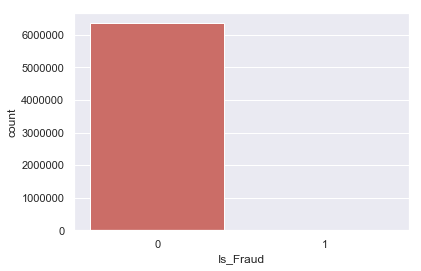

In [4]:
sns.countplot(x='Is_Fraud',data=whole_data, palette='hls')
plt.show()

#### Types of transactions

In [5]:
print(whole_data['Transaction_Type'].unique())

['BILL-PAYMENT' 'PURCHASE' 'CASH_OUT' 'DEBIT' 'CASH_IN']


#### Number of entries per customer

In [6]:
print("MAX:",whole_data.groupby(['Client_Id'])['Time_Stamp'].count().max())
print("MEAN:",whole_data.groupby(['Client_Id'])['Time_Stamp'].count().mean())
print("MIN:",whole_data.groupby(['Client_Id'])['Time_Stamp'].count().min())

MAX: 1010
MEAN: 6.692895109683694
MIN: 1


#### Transaction type for fradulent transaction

In [7]:
whole_data[whole_data['Is_Fraud']==1].groupby(['Transaction_Type']).count()['Is_Fraud']

Transaction_Type
CASH_OUT    9116
PURCHASE    9097
Name: Is_Fraud, dtype: int64

#### Transaction type for non- fradulent transaction

In [8]:
whole_data[whole_data['Is_Fraud']==0].groupby(['Transaction_Type']).count()['Is_Fraud']

Transaction_Type
BILL-PAYMENT    2151495
CASH_IN         1399284
CASH_OUT        2233384
DEBIT             41432
PURCHASE         528812
Name: Is_Fraud, dtype: int64

#### How efficient is Is_fault flagging??

In [9]:
((whole_data['Is_Fraud']==1) & (whole_data['Is_Flagged_Fraud']==1)).value_counts()

False    6372604
True          16
dtype: int64

In [10]:
print('percentage of data that was rightly classified:')
(16/len(whole_data[whole_data['Is_Fraud']==1]))*100

percentage of data that was rightly classified:


0.0878493383846703

## Feature Engineering

In [11]:
whole_data['Client_change_in_balance'] = whole_data['Cleint_New_Balance'] - whole_data['Client_Old_Balance']
whole_data['Merchant_change_in_balance'] = whole_data['Merchant_New_Balance'] - whole_data['Merchant_Old_Balance']
whole_data['percentage_of_balance'] = (whole_data['Amount']/whole_data['Client_Old_Balance']) *100

#### Some strange Facts

In [12]:
whole_data[(whole_data['Client_Old_Balance']==0) & (whole_data['Cleint_New_Balance']==0) & (whole_data['Amount']==0)].head()

,Time_Stamp,Transaction_Type,Amount,Client_Id,Client_Old_Balance,Cleint_New_Balance,Merchant_Id,Merchant_Old_Balance,Merchant_New_Balance,Is_Fraud,Is_Flagged_Fraud,Client_change_in_balance,Merchant_change_in_balance,percentage_of_balance
2736447,212,CASH_OUT,0.0,C1533131508,0.0,0.0,M1608767807,0.00,0.00,1,0,0.0,0.0,NaN
3247298,250,CASH_OUT,0.0,C1780497316,0.0,0.0,M20822566,0.00,0.00,1,0,0.0,0.0,NaN
3760289,279,CASH_OUT,0.0,C881485517,0.0,0.0,M1668533071,538547.63,538547.63,1,0,0.0,0.0,NaN
5563714,387,CASH_OUT,0.0,C647787714,0.0,0.0,M1913451129,7970766.57,7970766.57,1,0,0.0,0.0,NaN
5996408,425,CASH_OUT,0.0,C1654239658,0.0,0.0,C2068374328,76759.90,76759.90,1,0,0.0,0.0,NaN


If the Client old balance == 0 & Client new balance == 0 & Amount == 0
then transaction is fradulent

In [13]:
# Replacing NAN with 0
whole_data['percentage_of_balance'] = whole_data['percentage_of_balance'].fillna(0)
# Replacing infinity values with -1 (Rows with amount>0 and Client old balance == 0)
whole_data['percentage_of_balance'] = whole_data['percentage_of_balance'].replace([np.inf], -1)

#### Checking consistency of Data

#### Amount == Change in Balance

In [14]:
whole_data[whole_data['Amount']==abs(whole_data['Client_change_in_balance'])].groupby('Is_Fraud').size()

Is_Fraud
0    920951
1     18144
dtype: int64

#### Amount != Change in Balance

In [15]:
whole_data[whole_data['Amount']!=abs(whole_data['Client_change_in_balance'])].groupby('Is_Fraud').size()

Is_Fraud
0    5433456
1         69
dtype: int64

#### Amount distribution for fradulent (1) and non-fradulent (0) transactions

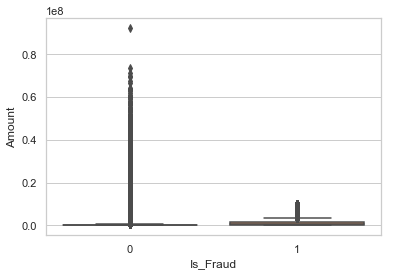

In [16]:
sns.set(style="whitegrid")
sns.boxplot(x="Is_Fraud", y="Amount", data=whole_data)
plt.show()

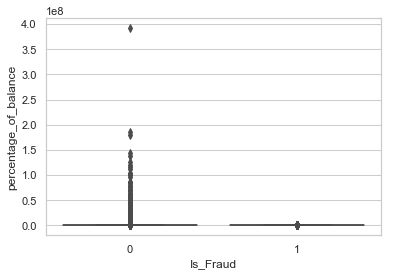

In [17]:
sns.boxplot(x="Is_Fraud", y="percentage_of_balance", data=whole_data)
plt.show()

In [18]:
model_data = whole_data.drop(columns=['Client_Id', 'Merchant_Id','Is_Flagged_Fraud','Time_Stamp'])
model_data = pd.get_dummies(model_data, columns=['Transaction_Type'])
model_data.head()

,Amount,Client_Old_Balance,Cleint_New_Balance,Merchant_Old_Balance,Merchant_New_Balance,Is_Fraud,Client_change_in_balance,Merchant_change_in_balance,percentage_of_balance,Transaction_Type_BILL-PAYMENT,Transaction_Type_CASH_IN,Transaction_Type_CASH_OUT,Transaction_Type_DEBIT,Transaction_Type_PURCHASE
0,9839.64,170136.0,160296.36,0.0,0.0,0,-9839.64,0.0,5.783397,1,0,0,0,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,-1864.28,0.0,8.773495,1,0,0,0,0
2,181.00,181.0,0.00,0.0,0.0,1,-181.00,0.0,100.000000,0,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,1,-181.00,-21182.0,100.000000,0,0,1,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,-11668.14,0.0,28.079463,1,0,0,0,0


In [19]:
from sklearn.preprocessing import StandardScaler
cols_to_norm = ['Amount','Client_Old_Balance','Cleint_New_Balance','Merchant_Old_Balance','Merchant_New_Balance','Client_change_in_balance',
'Merchant_change_in_balance','percentage_of_balance']
model_data[cols_to_norm] = StandardScaler().fit_transform(model_data[cols_to_norm])
model_data.head()

,Amount,Client_Old_Balance,Cleint_New_Balance,Merchant_Old_Balance,Merchant_New_Balance,Is_Fraud,Client_change_in_balance,Merchant_change_in_balance,percentage_of_balance,Transaction_Type_BILL-PAYMENT,Transaction_Type_CASH_IN,Transaction_Type_CASH_OUT,Transaction_Type_DEBIT,Transaction_Type_PURCHASE
0,-0.276350,-0.230542,-0.237475,-0.324504,-0.333994,0,-0.117119,-0.153388,-0.024027,1,0,0,0,0
1,-0.289043,-0.282022,-0.285699,-0.324504,-0.333994,0,-0.082703,-0.153388,-0.024018,1,0,0,0,0
2,-0.291722,-0.289306,-0.292333,-0.324504,-0.333994,1,-0.075439,-0.153388,-0.023750,0,0,0,0,1
3,-0.291722,-0.289306,-0.292333,-0.318278,-0.333994,1,-0.075439,-0.179163,-0.023750,0,0,1,0,0
4,-0.273440,-0.275001,-0.282105,-0.324504,-0.333994,0,-0.125009,-0.153388,-0.023962,1,0,0,0,0


Distributions: 

Number of fraud transactions- 18213
Number of non-fraud transactions- 6354407

By seeing the distributions we can have an idea how skewed are these features are. There are techniques that can help the distributions be less skewed. Let's try them !!

##### Random- Under Sampling
This method consists of removing data in order to have a more balanced dataset and thus avoiding the model to overfit.

Steps:

1) Determine how imbalanced is our class is.

2) Once we determine how many instances are considered fraud transactions (Fraud = "1") , we should bring the non-fraud transactions to the same amount as fraud transactions (assuming we want a 50/50 ratio)

3) After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to shuffle the data to see if our models can maintain a certain accuracy.

Note: The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss (bringing 18213 non-fraud transaction from 6354407 non-fraud transaction)

In [20]:
# Shuffle the data before creating the subsamples

model_data = model_data.sample(frac=1, random_state=10)

# amount of fraud classes 18213 rows.
fraud_df = model_data.loc[model_data['Is_Fraud'] == 1]
non_fraud_df = model_data.loc[model_data['Is_Fraud'] == 0][:18213]

combined_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
undersampled_data = combined_df.sample(frac=1, random_state=14)

undersampled_data.head()

,Amount,Client_Old_Balance,Cleint_New_Balance,Merchant_Old_Balance,Merchant_New_Balance,Is_Fraud,Client_change_in_balance,Merchant_change_in_balance,percentage_of_balance,Transaction_Type_BILL-PAYMENT,Transaction_Type_CASH_IN,Transaction_Type_CASH_OUT,Transaction_Type_DEBIT,Transaction_Type_PURCHASE
6370325,1.344915,0.066252,-0.292333,-0.324504,-0.054746,1,-4.512995,1.098149,-0.023750,0,0,1,0,0
1030418,-0.241758,-0.278452,-0.292333,-0.265903,-0.271287,1,-0.210911,-0.114966,-0.023750,0,0,1,0,0
6365470,0.667383,-0.080941,-0.292333,-0.324504,-0.333994,1,-2.675942,-0.153388,-0.023750,0,0,0,0,1
6365385,1.344915,0.066252,-0.292333,-0.324504,-0.054746,1,-4.512995,1.098149,-0.023750,0,0,1,0,0
2709806,-0.282109,-0.264849,-0.270193,-0.324504,-0.333994,0,-0.101503,-0.153388,-0.024018,1,0,0,0,0


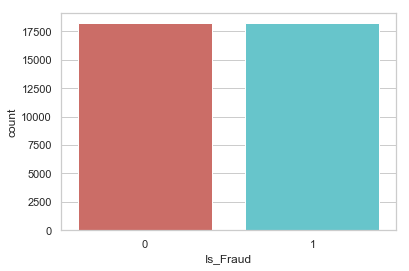

In [21]:
sns.countplot(x='Is_Fraud',data=undersampled_data, palette='hls')
plt.show()

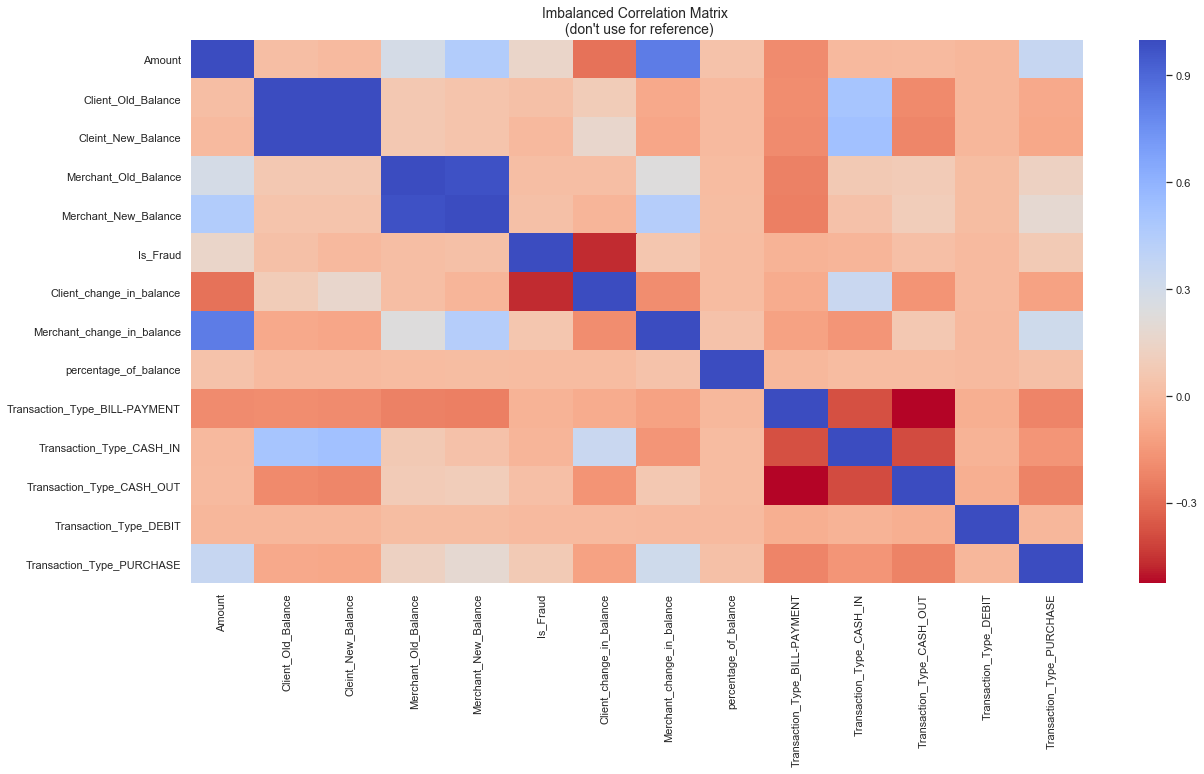

In [22]:
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))

corr = model_data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)
plt.show()

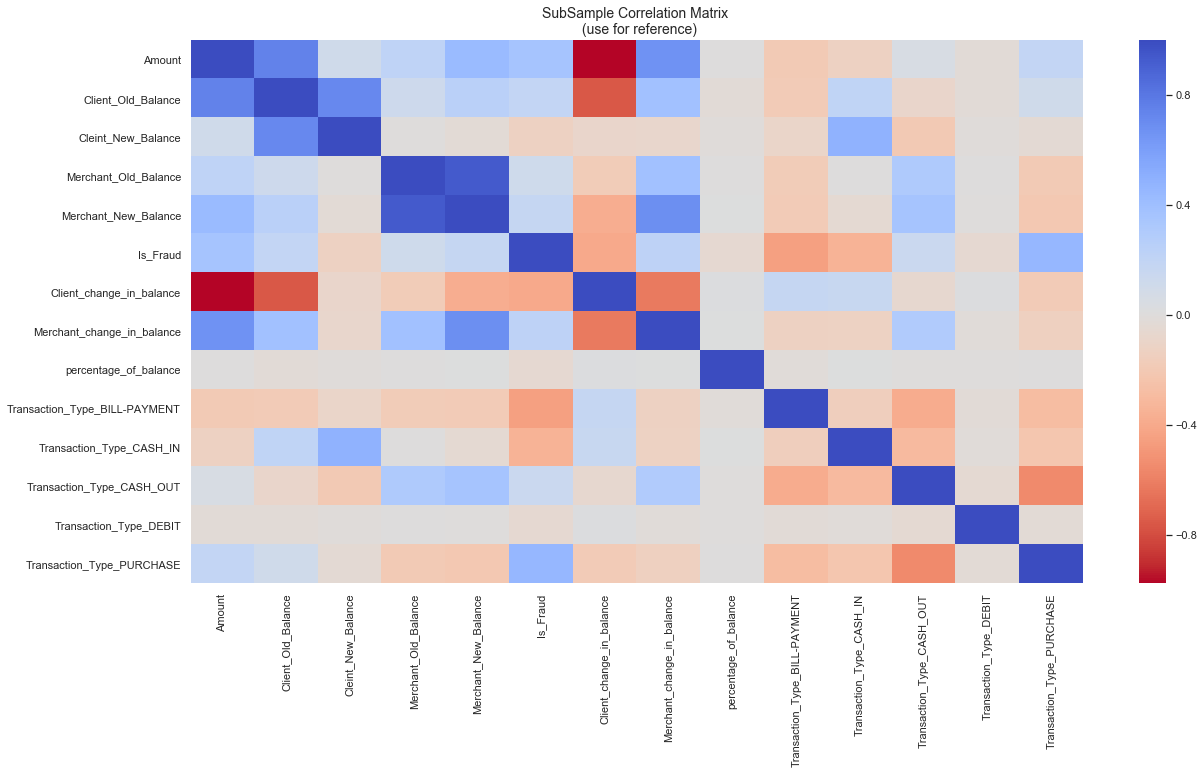

In [23]:
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
sub_sample_corr = undersampled_data.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

### Spliting the Data

In [24]:
from sklearn.model_selection import train_test_split
X = undersampled_data.iloc[:, undersampled_data.columns != 'Is_Fraud']
y = undersampled_data.iloc[:, undersampled_data.columns == 'Is_Fraud']
# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)
temp = X_test

In [25]:
print("Total number of transactions in unsampled  dataset: ", len(X_train)+len(X_test))
print("Total number of transactions in unsampled  dataset for training: ", len(X_train))
print("Total number of transactions in unsampled  dataset for testing: ", len(X_test))

Total number of transactions in unsampled  dataset:  36426
Total number of transactions in unsampled  dataset for training:  25498
Total number of transactions in unsampled  dataset for testing:  10928


In [26]:
features = X_train.columns
X_train = X_train.values
X_test = X_test.values

In [27]:
y_train = np.array(y_train).flatten()

### Logistic Regression

c:\users\pulkit\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning:

overflow encountered in exp



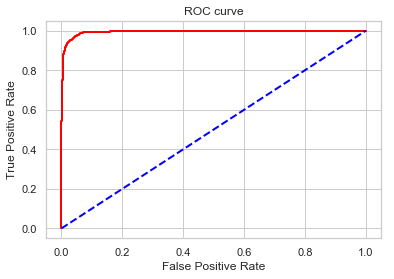

AUC: 0.9946000805218244
Accuracy: 0.9607430453879942
F1 score: 0.9604353038826893
Recall: 0.9540124587761085
Precision: 0.9669452181987
Confusion Matrix 
 [[5292  178]
 [ 251 5207]]


In [28]:
lr_model = LogisticRegressionCV(penalty='l2', cv=5,max_iter=2000)
lr_model = lr_model.fit(X_train, y_train)
y_pred_prob = lr_model.predict_proba(X_test)
y_pred = lr_model.predict(X_test)

fpr, tpr, thres = roc_curve(y_test, y_pred_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

print("AUC:",roc_auc_score(y_test, y_pred_prob[:,1]))         
print("Accuracy:",lr_model.score(X_test, y_test))
print("F1 score:",f1_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Confusion Matrix \n", confusion_matrix(y_test, y_pred))

### Model Interpretability

In [29]:
Logistic_regression_result = pd.DataFrame(data = {"Features":features,"Coefficient":lr_model.coef_[0]})
Logistic_regression_result.sort_values(by=['Coefficient'], ascending=False)

,Features,Coefficient
12,Transaction_Type_PURCHASE,13.806478
10,Transaction_Type_CASH_OUT,12.057359
3,Merchant_Old_Balance,1.400739
0,Amount,0.122540
1,Client_Old_Balance,-0.091463
2,Cleint_New_Balance,-0.634315
4,Merchant_New_Balance,-1.515592
11,Transaction_Type_DEBIT,-5.626641
5,Client_change_in_balance,-6.856816
6,Merchant_change_in_balance,-12.591956


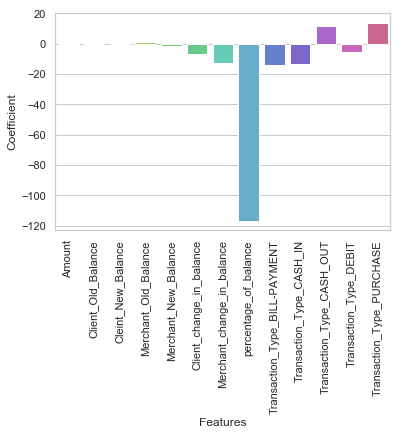

In [30]:
g = sns.barplot(x="Features", y="Coefficient", data=Logistic_regression_result, palette='hls')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.show()

### SVM with RBF kernel

c:\users\pulkit\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



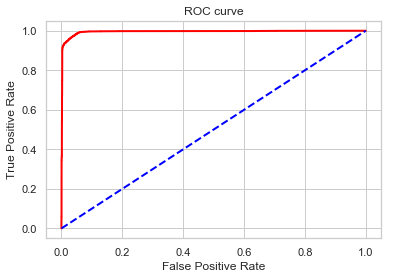

AUC: 0.9949346111874423
Accuracy: 0.9652269399707174
F1 score: 0.9648343512863226
Recall: 0.9551117625503848
Precision: 0.974756918474196
Confusion Matrix 
 [[5335  135]
 [ 245 5213]]


In [31]:
from sklearn.svm import SVC
svm_model = SVC(probability=True)
svm_model = svm_model.fit(X_train, y_train)
y_pred_prob = svm_model.predict_proba(X_test)
y_pred = svm_model.predict(X_test)

fpr, tpr, thres = roc_curve(y_test, y_pred_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

print("AUC:",roc_auc_score(y_test, y_pred_prob[:,1]))         
print("Accuracy:",svm_model.score(X_test, y_test))
print("F1 score:",f1_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Confusion Matrix \n", confusion_matrix(y_test, y_pred))

### Random Forest

c:\users\pulkit\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



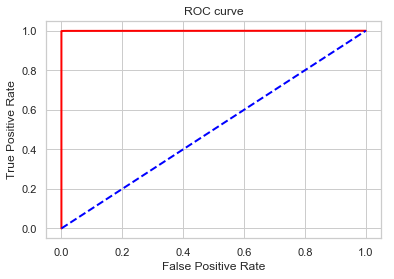

AUC: 0.999620703353446
Accuracy: 0.9988103953147877
F1 score: 0.99880810488677
Recall: 0.9979846097471601
Precision: 0.9996329601761791
Confusion Matrix 
 [[5468    2]
 [  11 5447]]


In [32]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train, y_train)
y_pred_prob = rf_model.predict_proba(X_test)
y_pred = rf_model.predict(X_test)

fpr, tpr, thres = roc_curve(y_test, y_pred_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

print("AUC:",roc_auc_score(y_test, y_pred_prob[:,1]))         
print("Accuracy:",rf_model.score(X_test, y_test))
print("F1 score:",f1_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Confusion Matrix \n", confusion_matrix(y_test, y_pred))

### KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier
num_nbrs = [5, 10, 15, 20, 25, 30]

for k in num_nbrs:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model = knn_model.fit(X_train, y_train)
    y_pred_prob = knn_model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_pred_prob[:,1])
    acc = knn_model.score(X_test, y_test)
    y_pred = knn_model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print("k={0}, auc: {1}, acc: {2},f1-score: {3},recall: {4},precision: {2}".format(k, auc , acc, f1 , recall , precision ))

k=5, auc: 0.993928021393885, acc: 0.9808748169838946,f1-score: 0.9810224280395896,recall: 0.9897398314400879,precision: 0.9808748169838946
k=10, auc: 0.9961938700249136, acc: 0.9799597364568082,f1-score: 0.98007098007098,recall: 0.9866251374129718,precision: 0.9799597364568082
k=15, auc: 0.9968205267681475, acc: 0.9777635431918009,f1-score: 0.9779671774412911,recall: 0.9880908757786735,precision: 0.9777635431918009
k=20, auc: 0.9969604686075418, acc: 0.9771229868228404,f1-score: 0.9773098565982937,recall: 0.9864419201172591,precision: 0.9771229868228404
k=25, auc: 0.9969700984014207, acc: 0.9754758418740849,f1-score: 0.9757114373753852,recall: 0.9862587028215464,precision: 0.9754758418740849
k=30, auc: 0.9969959397439513, acc: 0.9750183016105417,f1-score: 0.9752291080664186,recall: 0.9846097471601319,precision: 0.9750183016105417


### XG_Boost

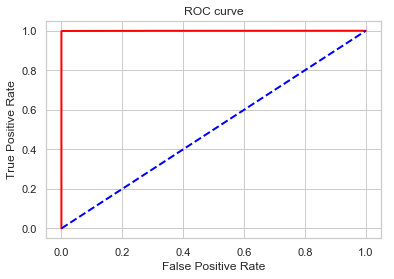

AUC: 0.9996554376012804
Accuracy: 0.9989019033674963
F1 score: 0.9988994864269993
Recall: 0.9978013924514474
Precision: 1.0
Confusion Matrix 
 [[5470    0]
 [  12 5446]]


In [34]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_prob = xgb_model.predict_proba(X_test)
y_pred = xgb_model.predict(X_test)

fpr, tpr, thres = roc_curve(y_test, y_pred_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

print("AUC:",roc_auc_score(y_test, y_pred_prob[:,1]))         
print("Accuracy:",xgb_model.score(X_test, y_test))
print("F1 score:",f1_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Confusion Matrix \n", confusion_matrix(y_test, y_pred))

### Building Trust in the Model

###### "The value is not in software, the value is in data, and this is really important for every single company, that they understand what data they’ve got."

LIME (Locally Interpretable Model-Agnostic Explanations), which is an algorithm that can explain the predictions of any classifier or regressor in a faithful way, by approximating it locally with an interpretable model.

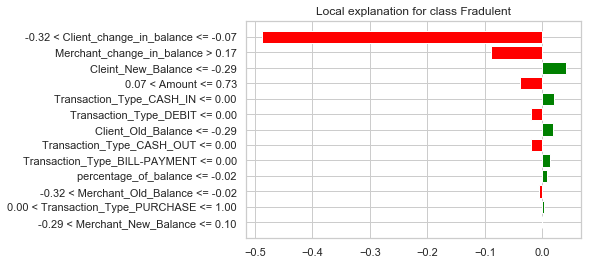

In [44]:
%matplotlib inline
import lime
import lime.lime_tabular
idx = 5
explainer = lime.lime_tabular.LimeTabularExplainer(X_train ,feature_names = features,class_names=['Non-fradulent','Fradulent'],mode='classification')
exp = explainer.explain_instance(X_test[idx], knn_model.predict_proba, num_features=13)
fig = exp.as_pyplot_figure()

In [45]:
exp.show_in_notebook(show_all=True)

LIME stands for Local Interpretable Model-Agnostic Explanations.
Local Interpretable: Explain the behaviour of the classifier "around" a given test transaction. 
Model-Agnostic: Explain any model choices without needing to “peak” into it

It is used for local intepretation of any possible model. It treats all model as a blackbox and try to interpret output by making chanes in input for that model.It specifies a range of feature values that are causing that feature to have its influence. 

For example in above example, features like "Client_change_in_balance","Merchant_change_in_balance" etc has a negative influence in the predicted value while features like "Cleint_New_Balance", "Transaction_Type_CASH_IN" etc has a positive influence.